In [3]:
!pip install kagglehub tensorflow pillow matplotlib numpy opencv-python scikit-learn ipywidgets


In [4]:
import kagglehub
import zipfile
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from IPython.display import display
from ipywidgets import FileUpload

In [5]:
# Download latest version of dataset
path = kagglehub.dataset_download("karakaggle/kaggle-cat-vs-dog-dataset")
print("Downloaded to:", path)


100%|██████████| 787M/787M [00:10<00:00, 80.2MB/s]

Extracting files...


Downloaded to: /root/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1


In [6]:
dataset_folder = path

print("Dataset extracted to:", dataset_folder)

# Optional: Check folder structure
for root, dirs, files in os.walk(dataset_folder):
    print(root, "->", len(files), "files")

Dataset extracted to: /root/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1
/root/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1 -> 0 files
/root/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a -> 2 files
/root/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages -> 0 files
/root/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat -> 12491 files
/root/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Dog -> 12470 files


In [7]:
img_size = 200
images = []
labels = []

# Adjust dataset_folder to point to the directory containing 'Cat' and 'Dog' folders
actual_images_path = os.path.join(dataset_folder, 'kagglecatsanddogs_3367a', 'PetImages')

# Get class names ('Cat', 'Dog')
classes = sorted([d for d in os.listdir(actual_images_path) if os.path.isdir(os.path.join(actual_images_path, d))])
print("Classes found:", classes)

for idx, cls in enumerate(classes):
    cls_path = os.path.join(actual_images_path, cls)
    count = 0
    for img_name in os.listdir(cls_path):
        if count >= 100:
            break
        img_path = os.path.join(cls_path, img_name)
        try:
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not read image {img_path}. Skipping.")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(idx)
            count += 1
        except Exception as e:
            print(f"Error loading image {img_path}: {e}. Skipping.")
            continue

images = np.array(images) / 255.0
labels = np.array(labels)
labels_cat = to_categorical(labels, num_classes=len(classes))

print("Total images loaded:", len(images))
print("Shape of images array:", images.shape)
print("Shape of labels array:", labels.shape)
print("Shape of one-hot encoded labels array:", labels_cat.shape)

Classes found: ['Cat', 'Dog']
Total images loaded: 200
Shape of images array: (200, 200, 200, 3)
Shape of labels array: (200,)
Shape of one-hot encoded labels array: (200, 2)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels_cat, test_size=0.2, random_state=42
)
print("Training images:", len(X_train))
print("Testing images:", len(X_test))


Training images: 160
Testing images: 40


In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    18,874,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,894,146 (72.08 MB)

 Trainable params: 18,894,146 (72.08 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
epochs = 10
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs
)


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5059 - loss: 4.9896 - val_accuracy: 0.5250 - val_loss: 1.1802
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.4681 - loss: 1.2057 - val_accuracy: 0.4750 - val_loss: 0.7859
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.6264 - loss: 0.6170 - val_accuracy: 0.5250 - val_loss: 0.7483
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.6694 - loss: 0.5651 - val_accuracy: 0.3500 - val_loss: 0.7234
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.8305 - loss: 0.4659 - val_accuracy: 0.4750 - val_loss: 0.7722
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.8840 - loss: 0.3492 - val_accuracy: 0.4250 - val_loss: 0.8313
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.9534 - loss: 0.2066 - val_accuracy: 0.4500 - val_loss: 1.4055
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.9389 - loss: 0.1623 - val_accuracy: 0.4500 - val_loss: 1.3618
Epoch 9/

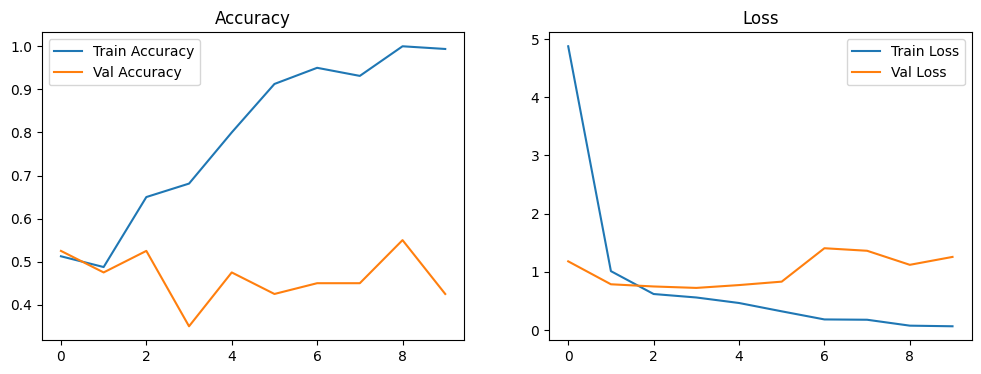

In [12]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()


In [13]:
model.save("cat_dog_model.h5")
print("Model saved as cat_dog_model.h5")


Model saved as cat_dog_model.h5
